In [5]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt 
import pyspark 
from pyspark.sql import SQLContext


conf = pyspark.SparkConf().setAll([('spark.executor.memory', '5g'), ('spark.driver.maxResultSize', '12g'), ('spark.driver.memory','38g')]) 
sc = pyspark.SparkContext(conf=conf) 
sqlContext = SQLContext(sc)

In [97]:
import time
from time import time
#from plot_utils import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from pyspark.mllib.tree import GradientBoostedTrees 
from pyspark.mllib.tree import GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils

In [7]:
feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
features=[a.strip() for a in feature_text.split(',')]

In [8]:
inputRDD=sc.textFile('newhiggs.csv') #Replace with actual path
inputRDD.first()

'0.000000000000000000e+00,1.043151855468750000e+00,1.656666755676269531e+00,1.403105974197387695e+00,1.209758877754211426e+00,-1.426052927970886230e+00,4.932132661342620850e-01,7.802757024765014648e-01,2.152585089206695557e-01,2.173076152801513672e+00,5.776452422142028809e-01,1.417294502258300781e+00,-1.009996175765991211e+00,0.000000000000000000e+00,9.834794998168945312e-01,-5.990352109074592590e-02,-2.087775468826293945e-01,1.274112224578857422e+00,1.075372815132141113e+00,1.202986687421798706e-01,7.256635427474975586e-01,0.000000000000000000e+00,1.256811141967773438e+00,9.555436968803405762e-01,9.902772307395935059e-01,1.076703906059265137e+00,5.007384419441223145e-01,1.032920122146606445e+00,9.087271094322204590e-01'

In [9]:
Data=(inputRDD.map(lambda line: [float(x.strip()) for x in line.split(',')]).map(lambda line: LabeledPoint(line[0], line[1:])))
Data.first()

LabeledPoint(0.0, [1.04315185546875,1.6566667556762695,1.4031059741973877,1.2097588777542114,-1.4260529279708862,0.4932132661342621,0.7802757024765015,0.21525850892066956,2.1730761528015137,0.5776452422142029,1.4172945022583008,-1.0099961757659912,0.0,0.9834794998168945,-0.059903521090745926,-0.2087775468826294,1.2741122245788574,1.0753728151321411,0.12029866874217987,0.7256635427474976,0.0,1.2568111419677734,0.9555436968803406,0.9902772307395935,1.0767039060592651,0.5007384419441223,1.0329201221466064,0.9087271094322205])

In [51]:
import pyspark
import os

#craete spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('higgs-boson-detection').getOrCreate()

#read dataset from local filesystem
data_location = os.path.join('','newhiggs.csv')
df = spark.read.load(data_location, format="csv", sep=",", inferSchema="true", header="true")
#df.show(10)
df.head(20)

[Row(0.000000000000000000e+000=0.0, 1.043151855468750000e+00=2.834810733795166, 1.656666755676269531e+00=0.948591411113739, 1.403105974197387695e+00=-1.6892415285110474, 1.209758877754211426e+00=0.4641239047050476, -1.426052927970886230e+00=0.5910764336585999, 4.932132661342620850e-01=0.6983218193054199, 7.802757024765014648e-01=0.9911948442459106, 2.152585089206695557e-01=0.11269906163215637, 2.173076152801513672e+00=1.0865380764007568, 5.776452422142028809e-01=1.08830988407135, 1.417294502258300781e+00=0.21376247704029083, -1.009996175765991211e+00=0.3283587694168091, 0.000000000000000000e+0013=0.0, 9.834794998168945312e-01=1.3211994171142578, -5.990352109074592590e-02=0.27324751019477844, -2.087775468826293945e-01=-1.1329693794250488, 1.274112224578857422e+00=0.0, 1.075372815132141113e+00=1.5234853029251099, 1.202986687421798706e-01=-0.8782563805580139, 7.256635427474975586e-01=0.4010399878025055, 0.000000000000000000e+0021=0.0, 1.256811141967773438e+00=1.1485846042633057, 9.5554369

In [52]:
(training, test) = df.randomSplit([0.7, 0.3])
training.count(), test.count()

(70102, 29897)

In [53]:
from pyspark.sql.functions import *
from pyspark.ml.linalg import DenseVector

training_dense  = training.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
training_dense = spark.createDataFrame(training_dense, ["label", "features"])

test_dense = test.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
test_dense = spark.createDataFrame(test_dense, ["label", "features"])

In [54]:
#GBT Model
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg


def as_old(v):
    if isinstance(v, ml_linalg.SparseVector):
        return mllib_linalg.SparseVector(v.size, v.indices, v.values)
    if isinstance(v, ml_linalg.DenseVector):
        return mllib_linalg.DenseVector(v.values)
    raise ValueError("Type not supported {0}".format(type(v)))

labelPoint_train = training_dense.rdd.map(lambda row: LabeledPoint(row.label, as_old(row.features)))
labelPoint_train.take(2)

[LabeledPoint(0.0, [0.27487966418266296,1.60991632938385,0.05867701396346092,0.766463577747345,1.5704559087753296,0.5127255916595459,-0.16044268012046814,-0.9324037432670593,1.0865380764007568,0.6094988584518433,-1.2899237871170044,0.7644549608230591,2.214872121810913,0.35809189081192017,1.6404410600662231,1.135448694229126,0.0,0.7664890885353088,0.9514561891555786,0.24677442014217377,0.0,0.4581441879272461,1.099364995956421,0.9927091002464294,0.6934192776679993,0.9657253623008728,0.8035697937011719,0.6996251940727234]),
 LabeledPoint(0.0, [0.27616071701049805,1.4151225090026855,1.1051454544067383,1.978718638420105,-0.1867901235818863,0.5316882729530334,1.6784143447875977,-1.4768004417419434,0.0,1.1170158386230469,0.7013920545578003,-1.221386432647705,1.1074360609054565,0.9632830023765564,-0.21919703483581543,0.4814158082008362,2.548224449157715,1.531517744064331,0.3068510890007019,1.2300786972045898,0.0,0.9263640642166138,1.0526174306869507,0.9901507496833801,1.2387562990188599,1.2319

In [100]:
start = time.time()
GBTmodel = GradientBoostedTrees.trainClassifier(labelPoint_train,categoricalFeaturesInfo={}, numIterations=10)
end = time.time()
print(f'Time taken to train model using GBT: {end - start} seconds')

predictions = GBTmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using GBT: 8.438256978988647 seconds
Test Error = 0.3283272569154096


In [101]:
start = time.time()
GBTmodel = GradientBoostedTrees.trainClassifier(labelPoint_train,categoricalFeaturesInfo={}, numIterations=15)
end = time.time()
print(f'Time taken to train model using GBT: {end - start} seconds')

predictions = GBTmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using GBT: 9.228494882583618 seconds
Test Error = 0.3169548784158946


In [102]:
start = time.time()
GBTmodel = GradientBoostedTrees.trainClassifier(labelPoint_train,categoricalFeaturesInfo={}, numIterations=20)
end = time.time()
print(f'Time taken to train model using GBT: {end - start} seconds')

predictions = GBTmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using GBT: 11.636063575744629 seconds
Test Error = 0.31167006723082585


In [103]:
start = time.time()
GBTmodel = GradientBoostedTrees.trainClassifier(labelPoint_train,categoricalFeaturesInfo={}, numIterations=25)
end = time.time()
print(f'Time taken to train model using GBT: {end - start} seconds')

predictions = GBTmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using GBT: 19.68382716178894 seconds
Test Error = 0.3049135364752316


In [104]:
start = time.time()
GBTmodel = GradientBoostedTrees.trainClassifier(labelPoint_train,categoricalFeaturesInfo={}, numIterations=30)
end = time.time()
print(f'Time taken to train model using GBT: {end - start} seconds')

predictions = GBTmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using GBT: 22.031901121139526 seconds
Test Error = 0.30477974378700207


In [105]:
start = time.time()
GBTmodel = GradientBoostedTrees.trainClassifier(labelPoint_train,categoricalFeaturesInfo={}, numIterations=35)
end = time.time()
print(f'Time taken to train model using GBT: {end - start} seconds')

predictions = GBTmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using GBT: 26.015262842178345 seconds
Test Error = 0.3006990667959996


In [106]:
start = time.time()
GBTmodel = GradientBoostedTrees.trainClassifier(labelPoint_train,categoricalFeaturesInfo={}, numIterations=40)
end = time.time()
print(f'Time taken to train model using GBT: {end - start} seconds')

predictions = GBTmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using GBT: 33.008830070495605 seconds
Test Error = 0.29795631668729305


In [108]:
start = time.time()
GBTmodel = GradientBoostedTrees.trainClassifier(labelPoint_train,categoricalFeaturesInfo={}, numIterations=45)
end = time.time()
print(f'Time taken to train model using GBT: {end - start} seconds')

predictions = GBTmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using GBT: 30.46180558204651 seconds
Test Error = 0.2974545941064321


In [109]:
start = time.time()
GBTmodel = GradientBoostedTrees.trainClassifier(labelPoint_train,categoricalFeaturesInfo={}, numIterations=50)
end = time.time()
print(f'Time taken to train model using GBT: {end - start} seconds')

predictions = GBTmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using GBT: 27.480563402175903 seconds
Test Error = 0.2951801184065291


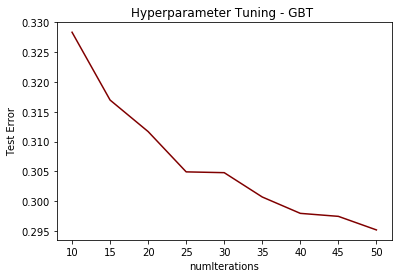

In [110]:
x = [10,15,20,25,30,35,40,45,50]
y = [0.3283272569154096,0.3169548784158946,0.31167006723082585,0.3049135364752316,0.30477974378700207,0.3006990667959996,0.29795631668729305,0.2974545941064321,0.2951801184065291]
plt.plot(x,y, color='maroon')
plt.xlabel('numIterations')
plt.ylabel('Test Error')
plt.title('Hyperparameter Tuning - GBT ')
plt.show()

In [61]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')

predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 2.868480682373047 seconds
Test Error = 0.34097066595310566


In [80]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=1, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 2.144352674484253 seconds
Test Error = 0.41713215372779877


In [65]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=2, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 1.9448232650756836 seconds
Test Error = 0.382948121885139


In [66]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=3, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 2.2609786987304688 seconds
Test Error = 0.37184332876208315


In [67]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 2.5651297569274902 seconds
Test Error = 0.3381944676723417


In [68]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=5, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 2.708146333694458 seconds
Test Error = 0.3302338027226812


In [75]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=6, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 2.791134834289551 seconds
Test Error = 0.3151821252968525


In [72]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=7, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 3.298335313796997 seconds
Test Error = 0.3086597317456601


In [77]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=8, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 3.922760248184204 seconds
Test Error = 0.30347526507676353


In [76]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=9, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 4.977488279342651 seconds
Test Error = 0.29514667023447166


In [78]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=10, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 6.7071404457092285 seconds
Test Error = 0.2877546242097869


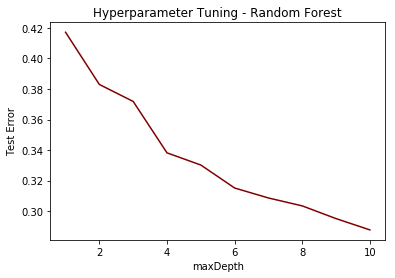

In [114]:
x = [1,2,3,4,5,6,7,8,9,10]
y = [0.41713215372779877,0.382948121885139,0.37184332876208315,0.3381944676723417,0.3302338027226812,0.3151821252968525,0.3086597317456601,0.30347526507676353,0.29514667023447166,0.2877546242097869]
plt.plot(x,y, color='maroon')
plt.xlabel('maxDepth')
plt.ylabel('Test Error')
plt.title('Hyperparameter Tuning - Random Forest')
plt.show()

In [87]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=10, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=6, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 2.604126214981079 seconds
Test Error = 0.3242800280964645


In [88]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=20, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=6, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 2.6574249267578125 seconds
Test Error = 0.316653844867378


In [89]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=30, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=6, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 2.8796119689941406 seconds
Test Error = 0.3144128173395324


In [92]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=35, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=6, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 2.9654343128204346 seconds
Test Error = 0.3127069605646051


In [91]:
start = time.time()
RFmodel = RandomForest.trainClassifier(labelPoint_train,
                                     numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=40, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=6, maxBins=32)
end = time.time()
print(f'Time taken to train model using RF: {end - start} seconds')
predictions  = RFmodel.predict(test_dense.rdd.map(lambda x: x.features.values))
labelsAndPredictions = test_dense.rdd.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test_dense.rdd.count())
print('Test Error = ' + str(testErr))

Time taken to train model using RF: 3.1425318717956543 seconds
Test Error = 0.3153828143291969


In [ ]:
x = [1,2,3,4,5,6,7,8,9,10]
y = [0.41713215372779877,0.382948121885139,0.37184332876208315,0.3381944676723417,0.3302338027226812,0.3151821252968525,0.3086597317456601,0.30347526507676353,0.29514667023447166,0.2877546242097869]
plt.plot(x,y, color='orange')
plt.xlabel('maxDepth')
plt.ylabel('Test Error')
plt.title('Hyperparameter Tuning - Random Forest')
plt.show()